## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
#**FINAL COPY

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

#**libraries we might need

import os
import sys
import pandas as pd
import numpy as np
from shutil import copyfile

import keras
from keras.datasets import cifar10
from keras import backend as K
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pyplot
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Import skimage modules
from skimage import data, img_as_float
from skimage import exposure

# Lets try augmenting a cifar10 image using these techniques
from skimage import data, img_as_float
from skimage import exposure
from skimage.util.dtype import dtype_range

from datetime import datetime
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
#all_xray_df.sample(3)

#all_xray_df.to_csv("test_data2.csv")

all_xray_df.sample(5)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
3794,00001034_005.png,No Finding,5,1034,73,M,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00001034_005.png
47794,00012113_000.png,Pleural_Thickening,0,12113,12,F,PA,2354,2017,0.143,0.143,NaN,/data/images_006/images/00012113_000.png
72457,00017852_013.png,No Finding,13,17852,31,F,PA,2670,2585,0.143,0.143,NaN,/data/images_008/images/00017852_013.png
9927,00002576_008.png,No Finding,8,2576,44,F,AP,2500,2048,0.168,0.168,NaN,/data/images_002/images/00002576_008.png
34579,00009107_011.png,Infiltration,11,9107,46,M,PA,2946,2965,0.143,0.143,NaN,/data/images_004/images/00009107_011.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

import skimage

def AHE(img):
    img_adapteq = skimage.exposure.equalize_adapthist(img, clip_limit=0.03)
    return img_adapteq

def label_pneumonia_dataframes(df):

    image_class = []

    print(df.head())
    print(df.tail())

    df_labels = df["Finding Labels"]

    list_of_findings = []

    for index, row in df.iterrows():
        label = row['Finding Labels']
        if "Pneumonia" in label or "Infiltration" in label:
            image_class.append("positive_pneumonia")
        else:
            image_class.append("negative_pneumonia")

    df["image_classes"] = image_class #*were going to create new column for data loader
                                        #*to easily know image class
    df.sample(4)

    return df


def get_pneumonia_dataframes_inner(file_name, df):
    #df = pd.read_csv(file_name)
    print(df.head())
    print(df.tail())

    df_labels = df["Finding Labels"]

    list_of_findings = []

    for da_label in df_labels:          #get the unique labelz bro!
        temp_list = da_label.split("|")
        for idx in temp_list:
            if idx not in list_of_findings:
                list_of_findings.append(idx)

    print("unique findings: ")
    for idx in list_of_findings:
        print(idx)

    # print("All findings")
    # for idx in list_of_findings:
    #    print(idx)

    list_of_findings.append("Pneumonia_or_Infiltration") #**well train just on this one now

    categoriez = []

    print("Findings with Pneumonia")
    temp_list = []

    for date, row in df.T.iteritems():
        #print(data)
        #print(row)
        total_label = row["Finding Labels"] #*go through each data frame!
        #print(total_label)
        temp_list = []
        for check_label in list_of_findings:
            if check_label == "Pneumonia_or_Infiltration":
                if "Pneumonia" in total_label or "Infiltration" in total_label:
                    temp_list.append("1") #*use strings for "BINARY" data loader
                else:
                    temp_list.append("0")
            else:
                if check_label in total_label:
                    temp_list.append(1)
                else:
                    temp_list.append(0)
        categoriez.append(temp_list)

    print("SUCCESS: SPLIT UP DATA FRAMES FOR DATAFRAME!")
        
    return list_of_findings, categoriez #*returns deduped findings, and categories for each dataframe!

def get_pneumonia_dataframes_outter(file_name, df):
    #file_name = "Data_Entry_2017.csv"
    list_of_findings, categoriez = get_pneumonia_dataframes_inner(file_name, df)

    cat_size = len(categoriez) - 1

    #df = pd.read_csv(file_name) #**need to add proper categorical columes to dataframe!

    catecory_dictionary = {}

    #create a bunch of lists in the dicationary !
    for idx in list_of_findings:
        catecory_dictionary[idx] = []

    for idx in categoriez:
        temp_throttle = 0
        for id in idx:                  #*add to multiple dictionaries!
            catecory_dictionary[list_of_findings[temp_throttle]].append(id)
            temp_throttle += 1 #iterate through the list_of_findings!

    print(catecory_dictionary)

    for key, value in catecory_dictionary.items():
        #print(key)
        temp_list = catecory_dictionary[key]
        df[key] = temp_list

    #patched_df = label_pneumonia_dataframes(all_xray_df)
    
    print("SUCCESS: DATA FRAME MODIFIED FOR TRAINING!")
    
    return df, list_of_findings #*return the dataframe! 

#datagen=ImageDataGenerator(height_shift_range=0.3, width_shift_range=0.3, shear_range = 20, horizontal_flip=0.2, rotation_range = 20, rescale=1./255.,validation_split=0.20) #*training and test validation data loader

file_name = '/data/Data_Entry_2017.csv'

patched_df, class_column_list = get_pneumonia_dataframes_outter(file_name, all_xray_df)

#patched_df.to_csv('training_data.csv')
#sys.exit(1)


        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
0                        0.143  0.143          NaN

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



SUCCESS: DATA FRAME MODIFIED FOR TRAINING!


In [4]:

print(patched_df.sample(5))

#sys.exit(1)

            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
12958  00003392_033.png     No Finding           33        3392           62   
29418  00007660_010.png    Atelectasis           10        7660           28   
22916  00006046_005.png     No Finding            5        6046           41   
42776  00011017_000.png         Nodule            0       11017           59   
20933  00005591_000.png     No Finding            0        5591           27   

      Patient Gender View Position  OriginalImage[Width  Height]  \
12958              M            AP                 2500     2048   
29418              M            PA                 2992     2991   
22916              F            AP                 2500     2048   
42776              M            PA                 2500     2048   
20933              F            PA                 2048     2500   

       OriginalImagePixelSpacing[x  ...  Mass  Nodule Atelectasis  \
12958                        0.168  ...  

In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import skimage

def save_model1(model, jsonfile, weightsfile):
    # serialize model to JSON
    model_json = model.to_json()
    with open(jsonfile, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(weightsfile)
    print("Saved model to disk")


def load_model1(jsonfile, weightsfile): #*should already have dense output numbers! 
    from keras import optimizers
    # load json and create model
    json_file = open(jsonfile, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(weightsfile)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer=optimizers.Adam(),
    #              metrics=['accuracy'])
    
    model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])
    
    model.summary()
    print("Loaded model from disk")
    return model


## Create your training and testing data:

In [6]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    return train_data, val_data

#**begin test model

import keras
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

import keras
import tensorflow as tf

import random

#STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

from tensorflow.python.client import device_lib


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    return my_idg


def generator_to_write_predictions(class_column_list, patched_df):
    class_column_list = ["Infiltration", "Pneumonia"] #*just narrow it down to notice 
                                                        #*Pneumonia images!
    
    batch_size = 64
    
    #datagen=ImageDataGenerator(zoom_range = [0.5,1.5], rotation_range = 15, shear_range = 15, rescale=1./255.,validation_split=0.20) #*training and test validation data loader
    
    #datagen=ImageDataGenerator(rescale=1./255.) #*training and test validation data loader
    
    datagen = ImageDataGenerator(rescale = 1./255.,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True
                                    )
    
    train_generator=datagen.flow_from_dataframe(
    dataframe=patched_df,
    directory="None",
    x_col="path",
    y_col="Pneumonia_or_Infiltration",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode="binary",
    target_size=(224,224)) #**use bigger images to get more xray data! :) 
    
    return train_generator

def make_train_gen(class_column_list, patched_df): #**lets provide the dataframe here
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo

    class_column_list = ["Infiltration", "Pneumonia"] #*just narrow it down to notice 
                                                        #*Pneumonia images!
    
    batch_size = 64
    
    #datagen=ImageDataGenerator(zoom_range = [0.5,1.5], rotation_range = 15, shear_range = 15, rescale=1./255.,validation_split=0.20) #*training and test validation data loader
    
    #datagen=ImageDataGenerator(zoom_range = [0.5,1.5], rotation_range = 15, rescale=1./255.,validation_split=0.20) #*training and test validation data loader
    
    datagen = ImageDataGenerator(rescale = 1./255,
                                      #horizontal_flip = True,
                                      #height_shift_range = 0.1,
                                      #width_shift_range = 0.1,
                                      rotation_range = 10,
                                      #shear_range = 0.1,
                                      zoom_range = 0.20, 
                                      brightness_range=[0.4, 1.1],
                                      samplewise_center = True,
                                      samplewise_std_normalization = True
                                      #validation_split=0.20
                                     )
    
    #datagen = ImageDataGenerator(rescale = 1./255,
    #                                  samplewise_center = True,
    #                                  samplewise_std_normalization = True
    #                                  #validation_split=0.20
    #                                 )
    
    train_generator=datagen.flow_from_dataframe(
    dataframe=patched_df,
    directory="None",
    x_col="path",
    y_col="Pneumonia_or_Infiltration",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="binary",
    target_size=(224,224)) #**use bigger images to get more xray data! :) 

    #valid_generator=datagen.flow_from_dataframe(
    #dataframe=patched_df,
    #directory="None",
    #x_col="path",
    #y_col=class_column_list,
    #subset="validation",
    #batch_size=batch_size,
    #seed=42,
    #shuffle=True,
    #class_mode="raw",
    #target_size=(512,512)) #**use bigger images to get more xray data! :) 
    
    print("Train Loader Ready")
    
    print("Number of Batches of Train_Generator: " + str(len(train_generator)))
    
    #print("Number of Batches of Valid_Generator: " + str(len(valid_generator)))
    #STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
    #STEP_SIZE_VALID=validation_set.n//validation_set.batch_size
    #STEP_SIZE_TEST=test_set.n//test_set.batch_size
    
    return train_generator#, valid_generator


def make_val_gen(class_column_list, patched_df):  #**lets provide the dataframe here
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    
    class_column_list = ["Infiltration", "Pneumonia"] #*just narrow it down to notice 
                                                        #*Pneumonia images!
    
    batch_size = 64
    
    #test_datagen=ImageDataGenerator(rescale=1./255.) #*test data loader

    test_datagen = ImageDataGenerator(rescale = 1./255.,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True
                                    )
    
    test_generator=test_datagen.flow_from_dataframe(
    dataframe=patched_df,
    directory="None",
    x_col="path",
    y_col="Pneumonia_or_Infiltration",
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode="binary",
    target_size=(224,224)) #*takes too long to train with larger images! maybe smaller can work 

    print("Test Loader Ready")
    
    print("Number of Batches Test_Generator: " + str(len(test_generator)))
    
    return test_generator

In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:

print(class_column_list)

class_len = len(class_column_list)

print("Number of Classes: " + str(class_len))

#patched_df_train = patched_df[3000:] #a big chunk of the data for training

#patched_df_test = patched_df[0:2999] #*a smaller chunk of the data for testing

df_sample_pos = patched_df[patched_df["Pneumonia"] == 1] #*these will have pneumonia
print("Length of Specific Pneumonia: " + str(len(df_sample_pos)))
#print(df_sample_pos.head(5))
df_sample_pos.head()

pne_positive_train = df_sample_pos[0 : 1000] #**use these for training #*train with one thousand
pne_positive_val = df_sample_pos[1000 : ] #**use these for validation. These have pneumonia. (PNE OR INFILTRATION)

df_sample_neg = patched_df[patched_df["Pneumonia"] == 0] #*these wont have pneumonia
non_pne_train = df_sample_neg[0 : 500]      #*validate with 500 positive
non_pne_val = df_sample_neg[500 : 1001]     #*validate with 500 negative

temp_combine = [pne_positive_train, non_pne_train]
patched_df_train = pd.concat(temp_combine)

temp_combine = [pne_positive_val, non_pne_val]
patched_df_test = pd.concat(temp_combine)

#make training set
train_generator = make_train_gen(class_column_list, patched_df_train)

test_generator = make_val_gen(class_column_list, patched_df_test) #* make testing set

write_to_csv_gen = generator_to_write_predictions(class_column_list, patched_df) #*write all labels to csv so we can see

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size + 1
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size + 1
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size + 1 #**add 1 to make sure we get that last batch! 
STEP_SIZE_WRITE_CSV = write_to_csv_gen.n//write_to_csv_gen.batch_size + 1

print("Some TEST labels from testing data.")
for idx in range(0, 5):
    valX, valY = train_generator.next()
    print(valY)

['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation', 'Pneumonia_or_Infiltration']
Number of Classes: 16
Length of Specific Pneumonia: 1431
Found 1500 validated image filenames belonging to 2 classes.
Train Loader Ready
Number of Batches of Train_Generator: 24
Found 932 validated image filenames belonging to 2 classes.
Test Loader Ready
Number of Batches Test_Generator: 15
Found 112120 validated image filenames belonging to 2 classes.
Some TEST labels from testing data.
[0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0.

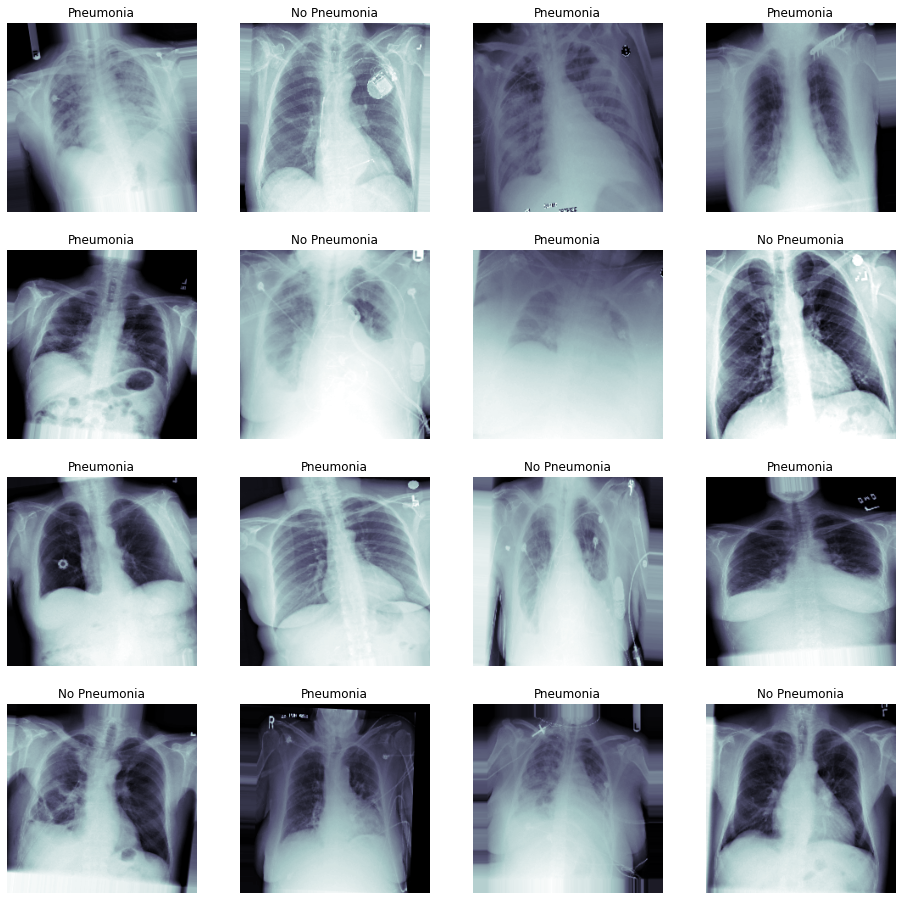

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y.any() == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
                #**function writes out predictions into csv so we can see what the model thinks! 
def write_results_csv(training_columns, pred, file_name, test_generator): #*send preddictions in as args! 
    pred_bool = (pred >0.5)
    predictions = pred_bool.astype(int)
    columns=training_columns
    #columns should be the same order of y_col
    results=pd.DataFrame(predictions, columns=columns)
    results["Filenames"]=test_generator.filenames
    ordered_cols=["Filenames"]+columns
    results=results[ordered_cols]#To get the same column order
    results.to_csv(file_name,index=False)
    print("Wrote Training Results To: " + file_name)

def load_pretrained_model(number_output, load_old_model=0, file_name_json=0, file_name_weights=0):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    from keras.optimizers import Adam
    number_output = 1 #**need to whittle it down to only look for pneumonia! 
    
    print(device_lib.list_local_devices()) #show if we have GPU ready or not! 
    
    if load_old_model:
        try:
            print("Loading Saved Model")
            model = load_model1(file_name_json, file_name_weights)
            print("SUCCESS: Returning saved model!")
            from datetime import datetime
            from keras.callbacks import ModelCheckpoint, LearningRateScheduler
            from keras.callbacks import ReduceLROnPlateau
            lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                           cooldown=0,
                                           patience=5,
                                           min_lr=0.5e-6)

            return model, lr_reducer
        except Exception as e:
            print("ERROR: Could Not Load Saved Model. TERMINATING")
            print(e)
            sys.exit(1)

    IMAGE_SIZE = [224, 224] #**use a little bigger images, to get more xray data! 
    vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    # here [3] denotes for RGB images(3 channels)

    # don't train existing weights GPU TOO SLOW
    for layer in vgg.layers:
        layer.trainable = False

    x = Flatten()(vgg.output)
    prediction = Dense(number_output, activation='sigmoid')(x)
    model = Model(inputs=vgg.input, outputs=prediction)
    #model.compile(loss='categorical_crossentropy',
    #              optimizer=optimizers.Adam(),
    #              metrics=['accuracy'])
    
    #model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])
    model.compile(optimizer = Adam(lr=0.0007), loss='binary_crossentropy', metrics=['binary_accuracy'])
    model.summary()

    from datetime import datetime
    from keras.callbacks import ModelCheckpoint, LearningRateScheduler
    from keras.callbacks import ReduceLROnPlateau
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                   cooldown=0,
                                   patience=5,
                                   min_lr=0.5e-6)
    
    print("SUCCESS: Returning built model!")
    
    return model, lr_reducer


In [11]:
def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [12]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

#early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1, patience=30)

#*well switch and use the modelcheckpoint to save the best model so we dont waste
#*anymore time! 
mc = ModelCheckpoint('best_final_model67.h5', monitor='val_binary_accuracy', mode='max', save_best_only=True)

#callbacks_list = [es, mc] #*were going to want to stop early so we dont waste too much time.
                    #val accuracy tops out at around 80% with all the augmentations. 

### Start training! 

In [13]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

print(class_column_list)
print(test_generator.filenames)

load_old_model = False #*load saved model! 
load_old_model2 = True #*load model from checkpoint
save_model = False    #*lets just use the checkpoint func to save it! 
train_model = True  #*Might not need to train if were just testing

if load_old_model:
    file_name_json = "model.json.2281174"
    file_name_weights = "model_weights.2281174"
else:
    file_name_json = 0
    file_name_weights = 0

print("Loading Model")

try:
    model, lr_reducer = load_pretrained_model(class_len, load_old_model, file_name_json, file_name_weights)
    print("SUCCESS: LOADED MODEL FROM DISK")
except Exception as e:
    print("ERROR: Could Not Load Model Success. Terminating!")
    sys.exit(1)

if load_old_model2: #*load from checkpoint
    # load a saved model
    from keras.models import load_model
    model = load_model('best_final_model66.h5')
    print("Loaded H5 Model Success")

print("SUCCESS: LOADED MODEL")
    
#checkpoint = ModelCheckpoint(filepath='mymodel.h5',
#                               verbose=1, save_best_only=True)

#callbacks = [checkpoint, lr_reducer]

start = datetime.now()

print("Begin Training")

callbacks_list = [es, mc] #*were going to want to stop early so we dont waste too much time.

if train_model: #*might not want to train it! 
    print("Number of Training Batches: " + str(len(train_generator)))
    print("Number of Validation Batches: " + str(len(test_generator)))
    history = model.fit_generator(train_generator,
                        steps_per_epoch=STEP_SIZE_TRAIN,
                        epochs = 15, verbose=1,
                        validation_data = test_generator,
                        validation_steps = STEP_SIZE_TEST,
                        callbacks = callbacks_list)
else:
    print("Were not going to train")

if save_model:
    try:
        #model.save(model_file_name)

        file_ext = str(random.randint(5, 9999999))

        model_json = "model.json." + file_ext
        weights_file = "model_weights." + file_ext

        save_model1(model, model_json, weights_file)
        model.save('my_model_learnt.h5')
        print("Model Backup Saved to Disk" + model_json)
    except Exception as e:
        print("Couldnt Save Model!")
        print(e)

duration = datetime.now() - start
print("Training completed in time: ", duration)

print("Done Training")

#sys.exit(1)


['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation', 'Pneumonia_or_Infiltration']
['/data/images_009/images/00018464_027.png', '/data/images_009/images/00018494_004.png', '/data/images_009/images/00018525_000.png', '/data/images_009/images/00018527_011.png', '/data/images_009/images/00018527_012.png', '/data/images_009/images/00018574_020.png', '/data/images_009/images/00018610_029.png', '/data/images_009/images/00018721_007.png', '/data/images_009/images/00018840_041.png', '/data/images_009/images/00018843_000.png', '/data/images_009/images/00018921_010.png', '/data/images_009/images/00018921_021.png', '/data/images_009/images/00018921_036.png', '/data/images_009/images/00018921_062.png', '/data/images_009/images/00018926_001.png', '/data/images_009/images/00018960_022.png', '/data/images_009/images/00018960_023.png', '/data/images_009/

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


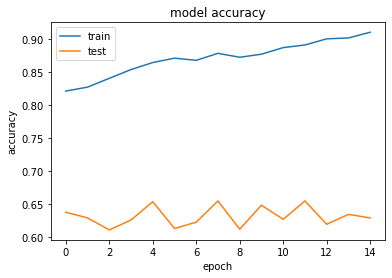

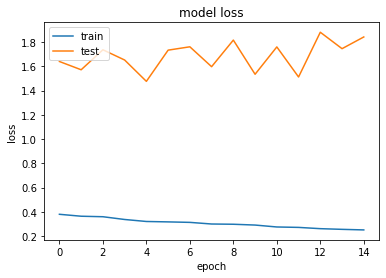

In [14]:
#**well use this cell to plot the training stats
try:
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
except Exception as e:
    print("Could Not PLot History")
    print(e)

In [15]:
#**We can start second part of project here, so we dont have to keep retraining! 

print(model.summary())

print(dir(test_generator))

valX, valY = test_generator.next()

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("---EVALUATE TRAIN GENERATOR--")
print("\n\n")
train_generator.reset()

score = model.evaluate(train_generator)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

print("---EVALUATE EVAL GENERATOR--")
print("\n\n")
test_generator.reset()

score = model.evaluate(test_generator)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

#pred_trained=model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose=1)

#pred_trained=model.predict_generator(test_generator, steps=1,verbose=1)

#pred_Y = model.predict(valX, batch_size = 64, verbose = True)

#print(pred_trained)

#y_pred = np.argmax(pred_trained, axis=1)
#print('Confusion Matrix')
#print(confusion_matrix(test_generator.labels, y_pred))
#print('Classification Report')
#target_names = ['Pneumonia_or_Infiltration']
#print(classification_report(test_generator.labels, y_pred, target_names=target_names))

#print(test_generator.labels)

#print(classification_report(valY, y_pred, target_names=test_generator.labels))

#sys.exit(1)

#**Write our predictions to csv file so we can manually look at them if we want to

#file_name = "trained_predictions8.csv"
#class_column_list = ["Infiltration", "Pneumonia"] #*whittle it down to just 2
                                                    #*looking for pneumonia
#write_results_csv(class_column_list, pred_trained, file_name, write_to_csv_gen) #*WRITE TRAINED MODEL RESULTS

#print("Predictions Written To: " + file_name)

#sys.exit(1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

24/24 [==============================] - 42s 2s/step
Making Predictions from Training data
Predicting Batch: 0
64/64 [==============================] - 1s 9ms/step
Predicting Batch: 1
64/64 [==============================] - 1s 9ms/step
Predicting Batch: 2
64/64 [==============================] - 1s 9ms/step
Predicting Batch: 3
64/64 [==============================] - 1s 9ms/step
Predicting Batch: 4
64/64 [==============================] - 1s 9ms/step
-----------
Making Predictions from Validation data
Predicting Batch: 0
64/64 [==============================] - 1s 9ms/step
Predicting Batch: 1
64/64 [==============================] - 1s 9ms/step
Predicting Batch: 2
64/64 [==============================] - 1s 9ms/step
Predicting Batch: 3
64/64 [==============================] - 1s 9ms/step
Predicting Batch: 4
36/36 [==============================] - 0s 11ms/step
Prediction Data from Training Data.
(36,)
[0.99556124 0.9537369  0.7234968  0.98508155 0.79161143 0.7864636
 0.53900623 0.9897

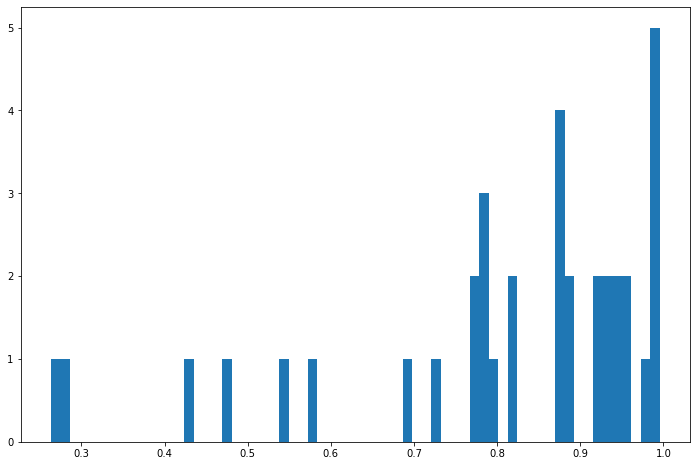

In [28]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc


# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    all_labels = ['Pneumonia_or_Infiltration']
    
    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
train_generator.reset() # resetting generator
y_pred = model.predict_generator(train_generator, verbose = True)

y_pred = np.argmax(y_pred, axis=1)

#*begin write output data to disk


#np.savetxt("pred66.csv", y_pred, delimiter=",") #*WRITING PREDICTIONS TO DISK

#np.savetxt("labels66.csv", train_generator.labels, delimiter=",") #*WRITE REAL LABES TO DISK

#print("Success: Wrote Predictions and labels to disk for analysis")

#print("Trying with just model.predict")

#*lets predict 3 big batches

train_generator.reset()

x_list = []
y_list = []
pred_list = []
print("Making Predictions from Training data")

for idx in range(0, 5):

    print("Predicting Batch: " + str(idx))    

    valX, valY = train_generator.next() #**training data

    pred_Y = model.predict(valX, batch_size = 64, verbose = True).ravel()
    
    x_list.append(valX)
    y_list.append(valY)
    pred_list.append(pred_Y)
    
pred_Y = np.concatenate(pred_list)
valY = np.concatenate(y_list)
valX = np.concatenate(x_list)

print("-----------") #* begin validation predictions. Model does not do well here! :( 

x_list_val = []
y_list_val = []
pred_list_val = []
print("Making Predictions from Validation data")

for idx in range(0, 5):

    print("Predicting Batch: " + str(idx))    

    valX, valY = test_generator.next() #*validation data

    pred_Y = model.predict(valX, batch_size = 64, verbose = True).ravel()
    
    x_list_val.append(valX)
    y_list_val.append(valY)
    pred_list_val.append(pred_Y)
    
pred_Y_val = np.concatenate(pred_list) #**predictions stored in numpy arrays
valY_val = np.concatenate(y_list) #**true labels stored in numpy arrays
valX_val = np.concatenate(x_list) #**the images stored in numpy arrays



#print(pred_Y)

#*end 

print("Prediction Data from Training Data.")

print(pred_Y.shape)
print(pred_Y)
print(valY)
# Look at the distribution of the prediction probabilities
plt.hist(pred_Y, bins=64)

test_generator.reset()
train_generator.reset()

Prediction Data from Validation Data.
(320,)
[0.536561   0.6161627  0.9888666  0.92482054 0.99846184 0.7870595
 0.87126505 0.997267   0.9656164  0.76479274 0.8749583  0.37879196
 0.9925411  0.56115746 0.9381947  0.8487495  0.9855295  0.21103086
 0.99770516 0.18253179 0.99149317 0.63764036 0.9861455  0.9626946
 0.99724185 0.41203916 0.92539537 0.18838175 0.28825796 0.9900092
 0.9625929  0.8820961  0.8238923  0.51301026 0.5725452  0.9968592
 0.9956593  0.8687572  0.9793017  0.87038934 0.6034022  0.47512922
 0.883865   0.66762114 0.9621156  0.9935221  0.99166167 0.9917453
 0.89726263 0.9329965  0.8821903  0.51678056 0.2464586  0.8907072
 0.8954536  0.31073323 0.57048464 0.9689192  0.99228853 0.1406969
 0.91550785 0.981212   0.64687026 0.9980603  0.964728   0.36269408
 0.83310264 0.56687254 0.70200014 0.88519895 0.33481634 0.9694979
 0.9504779  0.83164424 0.9966761  0.03401239 0.9498966  0.5559718
 0.8865202  0.43853226 0.98035014 0.99619776 0.99449843 0.896255
 0.16642118 0.08630411 0.133

(array([ 2.,  1.,  1.,  2.,  6.,  2.,  3.,  4.,  1.,  1.,  6.,  2.,  1.,
         1.,  2.,  2.,  1.,  4.,  5.,  1.,  3.,  3.,  1.,  1.,  2.,  2.,
         1.,  1.,  1.,  5.,  0.,  1.,  2.,  1.,  5.,  4.,  3.,  1.,  4.,
         2.,  6.,  1.,  2.,  2.,  3.,  6.,  3.,  1.,  4.,  2.,  4.,  4.,
         5.,  7.,  7., 11., 13.,  4.,  6., 14., 18., 24., 29., 53.]),
 array([0.02407584, 0.0393131 , 0.05455035, 0.0697876 , 0.08502486,
        0.10026211, 0.11549936, 0.1307366 , 0.14597386, 0.16121112,
        0.17644837, 0.19168562, 0.20692287, 0.22216013, 0.23739737,
        0.25263464, 0.2678719 , 0.28310913, 0.2983464 , 0.31358364,
        0.32882088, 0.34405816, 0.3592954 , 0.37453264, 0.3897699 ,
        0.40500715, 0.4202444 , 0.43548167, 0.4507189 , 0.46595618,
        0.48119342, 0.49643067, 0.5116679 , 0.5269052 , 0.54214245,
        0.55737966, 0.57261693, 0.5878542 , 0.6030914 , 0.6183287 ,
        0.63356596, 0.6488032 , 0.66404045, 0.6792777 , 0.69451493,
        0.7097522 , 0.7249

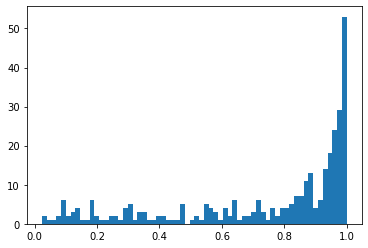

In [29]:
print("Prediction Data from Validation Data.")

print(pred_Y_val.shape)
print(pred_Y_val)
print(valY_val)
# Look at the distribution of the prediction probabilities
plt.hist(pred_Y_val, bins=64)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

---ROC CURVE FROM TRAINING DATA---


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:88: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


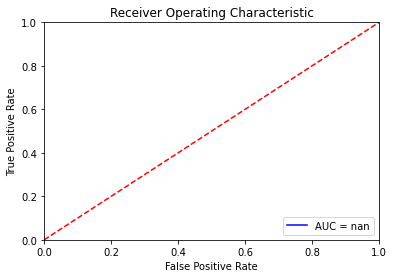

In [17]:
#lets try to generate ROC curve here
from sklearn.metrics import roc_curve
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(valY, pred_Y)
import sklearn.metrics as metrics

from sklearn.metrics import auc
#auc_keras = auc(fpr_keras, tpr_keras)

print("---ROC CURVE FROM TRAINING DATA---")

fpr, tpr, threshold = metrics.roc_curve(valY, pred_Y)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---ROC CURVE FROM VALIDATION DATA---


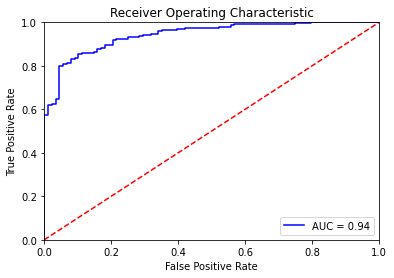

In [18]:
print("---ROC CURVE FROM VALIDATION DATA---")

fpr, tpr, threshold = metrics.roc_curve(valY_val, pred_Y_val)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [19]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
#my_model.load_weights(weight_path)
#pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

In [20]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [21]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [22]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

64/64 [==============================] - 1s 10ms/step
Predictions
[0.8302481  0.7000562  0.98426163 0.51031864 0.85666555 0.9831218
 0.27174026 0.9983191  0.7325475  0.965939   0.9440679  0.96112645
 0.593478   0.9544897  0.96680945 0.9574363  0.27100238 0.96356773
 0.9724151  0.26964426 0.91274595 0.9181862  0.36628973 0.5956927
 0.8485263  0.94657946 0.9956536  0.6026825  0.8960023  0.86016625
 0.63341105 0.9734697  0.9732564  0.5327846  0.78101873 0.8514007
 0.966155   0.9977564  0.86400473 0.9716755  0.49106798 0.79837674
 0.9815006  0.5641019  0.32557464 0.49798754 0.97695845 0.73444885
 0.9467217  0.98296726 0.13049419 0.8283368  0.9462134  0.83855
 0.89851725 0.97314376 0.0318727  0.97481096 0.9630634  0.6009156
 0.96332645 0.967198   0.0904188  0.94718504]
Labels
[1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1.]
Predictions from Train

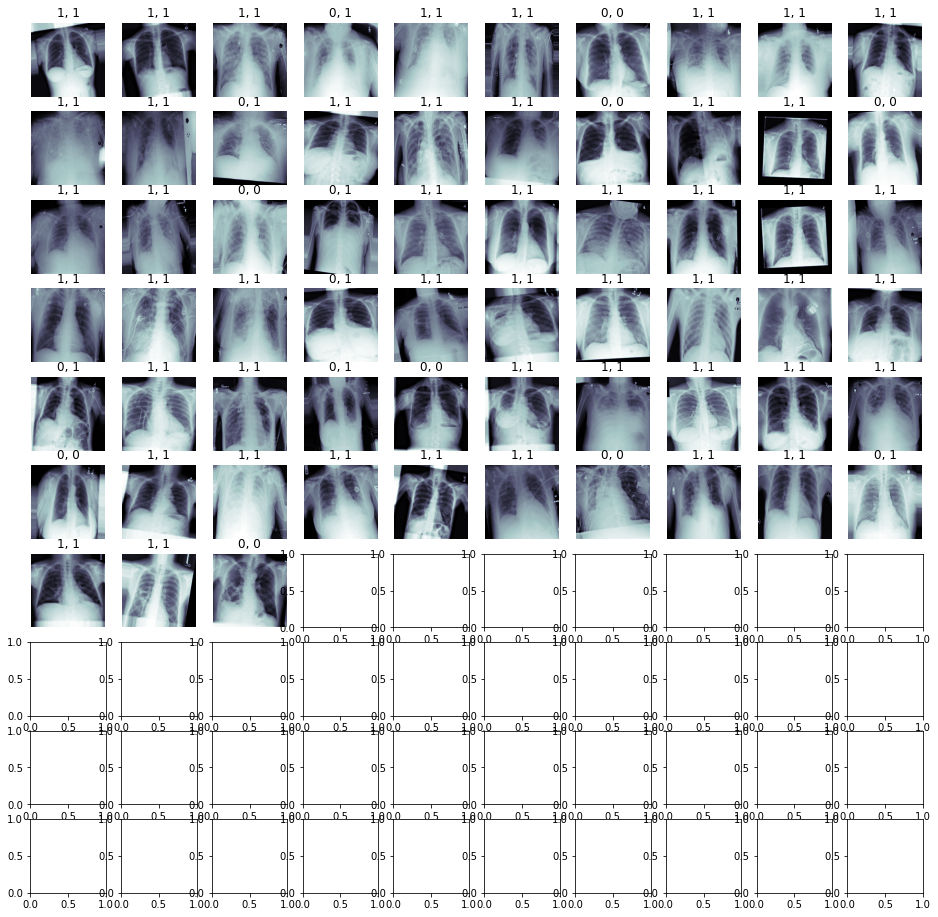

In [35]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

train_generator.reset()

valX, valY = train_generator.next() #*validation data

pred_Y = model.predict(valX, batch_size = 64, verbose = True).ravel()

print("Predictions")
print(pred_Y)

print("Labels")
print(valY)

print("Predictions from Training Data")

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, true_label, c_ax) in zip(valX[0:63], pred_Y[0:63], valY[0:63], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     print("Prediction:  " + str(c_y))
     print("True Labe: " + str(true_label))
     c_y = true_label
     #print(pred_Y[i])
     if c_y == 1: 
         if pred_Y[i] > 0.48:
             c_ax.set_title('1, 1')
         else:
             c_ax.set_title('1, 0')
     else:
         if pred_Y[i] > 0.48: 
             c_ax.set_title('0, 1')
         else:
             c_ax.set_title('0, 0')
     c_ax.axis('off')
     i=i+1

64/64 [==============================] - 1s 10ms/step
Predictions
[0.9847829  0.96088547 0.9284768  0.9694493  0.97877276 0.9420649
 0.98817724 0.9696555  0.9977824  0.8356361  0.9724237  0.97845364
 0.9827404  0.98639435 0.96213734 0.9612974  0.9089447  0.9854172
 0.959908   0.9917384  0.97846234 0.9813224  0.9907023  0.9988557
 0.9678964  0.9863219  0.9211919  0.85866684 0.99318814 0.8078662
 0.96804607 0.9426046  0.91090137 0.993997   0.90735364 0.9629822
 0.9653804  0.93117815 0.92389244 0.8774086  0.9233375  0.45607194
 0.85510993 0.9240833  0.92315066 0.99489105 0.9828439  0.962888
 0.62873125 0.9820373  0.97069037 0.9891151  0.9461171  0.90397316
 0.98316413 0.90489036 0.78241706 0.8108746  0.44167134 0.73341227
 0.87440664 0.9488882  0.9142142  0.95630205]
Labels
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Predictions from Valid

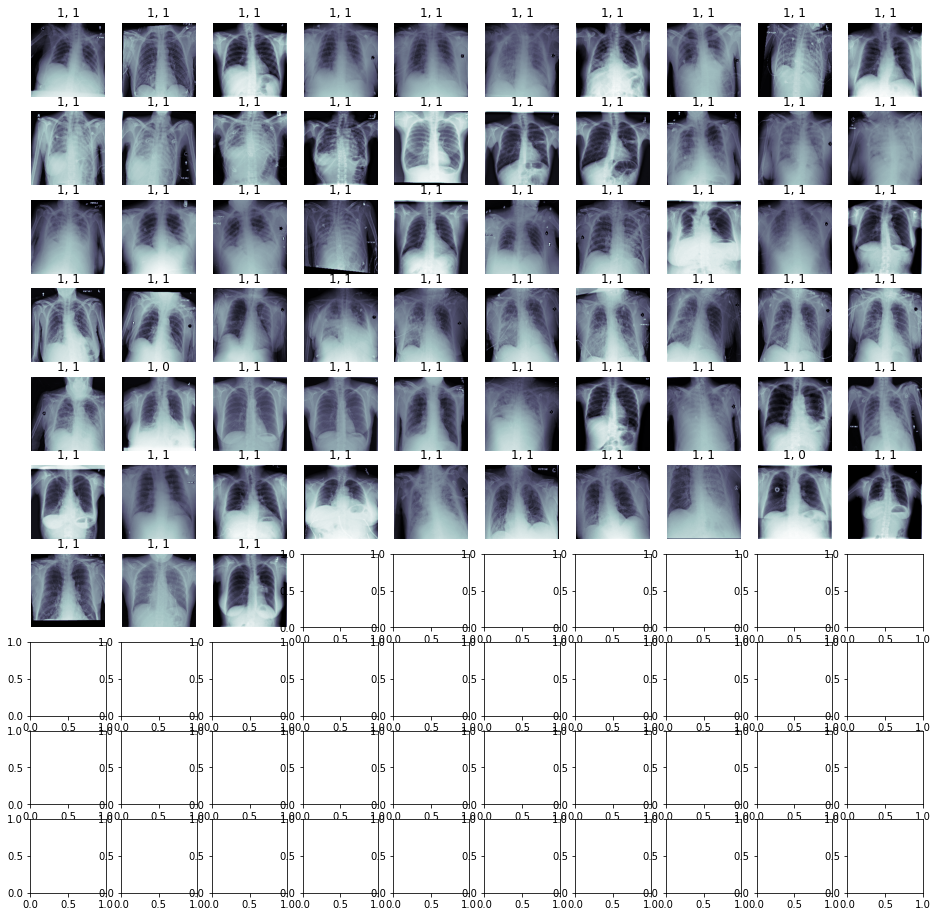

In [36]:
test_generator.reset()

valX, valY = test_generator.next() #*validation data

pred_Y = model.predict(valX, batch_size = 64, verbose = True).ravel()

print("Predictions")
print(pred_Y)

print("Labels")
print(valY)

print("Predictions from Validation Data")

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, true_label, c_ax) in zip(valX[0:63], pred_Y[0:63], valY[0:63], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     print("Prediction:  " + str(c_y))
     print("True Labe: " + str(true_label))
     c_y = true_label
     #print(pred_Y[i])
     if c_y == 1: 
         if pred_Y[i] > 0.48:
             c_ax.set_title('1, 1')
         else:
             c_ax.set_title('1, 0')
     else:
         if pred_Y[i] > 0.48: 
             c_ax.set_title('0, 1')
         else:
             c_ax.set_title('0, 0')
     c_ax.axis('off')
     i=i+1

In [37]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)
print("Wrote Model to Disk")

Wrote Model to Disk
